## Notebook to run the fitter on multiple ramps

In [1]:
import numpy as np
from ramp_utils.ramp import RampTimeSeq,RampMeasurement
from ramp_utils.fitter import IterativeFitter
import time, sys, pickle, bz2
from multiprocessing import Pool
from scipy.interpolate import interp1d

%matplotlib notebook

### Set the working directory for saving the results

In [2]:
dirsave = '/user/gennaro/Functional_work/Up_the_ramp_myfork/Simulations_results/'
filename = 'Test_3.pbz2'

#### These are two auxiliary function used to generate CRhits 
#### A good number for WFC3 can be found in http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2009-40.pdf, with ~ 2.5e-5 hits per second per pixel


In [3]:
def generateCR_DNs(size):
    '''
    Just generate random uniform DNs
    '''
    return 1000.*np.random.uniform(size=size)

def generateCR(myramp,CRrate=2.5e-5):
    '''
    Main CR generation function that generates CR hit times and depositied counts
    
    :CRrate:
        rate of CR hits in hits/second
    '''
    
    myCRnumber = np.random.poisson(lam=CRrate*myramp.read_times[-1])

    if myCRnumber > 0:
        mytimes = myramp.read_times[-1]*np.random.uniform(size=myCRnumber)
        mycounts = generateCR_DNs(myCRnumber)
        myCRdict = {'times':mytimes.tolist(),'counts':mycounts.tolist()}
    else:
        myCRdict = None

    return myCRdict

#### Auxiliary function to generate cumulative background electrons
Used to test the fitter with non-constant flux

In [4]:
def get_vbg_electrons(times,vbg_cr,meas,mean_bg_cr=None):
    '''
    Given a tabulated form for the variable background time dependency,
    generate a number of electrons per each read interval in the ramp
    
    :times:
        times at which the countrate is tabulated
    
    :vbg_cr:
        values of the time variable background at those times   
    
    :meas:
        a RampMeasurement object
    
    :mean_bg_cr:
        the mean value for normalizing the countrate within the interval    
    '''

    
    #Create an interpolator from the tabulated values and interpolate at the ramp read times
    bg_int = interp1d(times,vbg_cr,'quadratic')
    varbg = bg_int(meas.RTS.read_times)

    #Normalize if requested
    if mean_bg_cr is not None:
        dt = meas.RTS.read_times[-1]-meas.RTS.read_times[0]
        t_avg = np.trapz(varbg,meas.RTS.read_times) / dt
        varbg = varbg/t_avg * mean_bg_cr

    #Get the total accumulated electrons
    bg_e=[0]
    bg_e.extend([np.random.poisson(lam=vb*dt) for vb,dt in zip(0.5*(varbg[1:]+varbg[:-1]),meas.RTS.read_times[1:]-meas.RTS.read_times[:-1]) ])
    bg_e = np.asarray(bg_e)
    
    return np.cumsum(bg_e)


### Define the read sequences

<IPython.core.display.Javascript object>


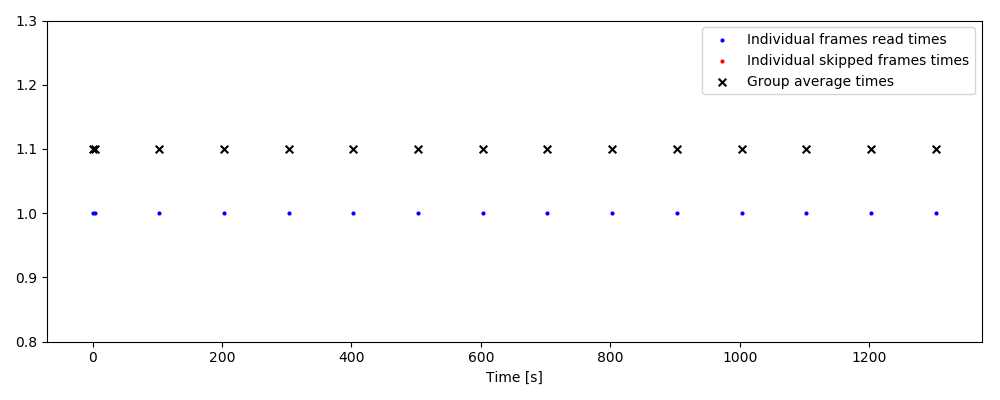

In [5]:
dt,nf,ns,ng = 6.,1,0,17
myramp1 = RampTimeSeq('GENERIC',ng,nframes=nf, nskips=ns, read_times=dt*np.arange(ng*(nf+ns)))

dt,nf,ns,ng = 8.,1,0,13
myramp2 = RampTimeSeq('GENERIC',ng,nframes=nf, nskips=ns, read_times=dt*np.arange(ng*(nf+ns)))

dt,nf,ns,ng = 12.,1,0,9
myramp3 = RampTimeSeq('GENERIC',ng,nframes=nf, nskips=ns, read_times=dt*np.arange(ng*(nf+ns)))

dt,nf,ns,ng = 16.,1,0,7
myramp4 = RampTimeSeq('GENERIC',ng,nframes=nf, nskips=ns, read_times=dt*np.arange(ng*(nf+ns)))

dt,nf,ns,ng = 24.,1,0,5
myramp5 = RampTimeSeq('GENERIC',ng,nframes=nf, nskips=ns, read_times=dt*np.arange(ng*(nf+ns)))


myramp6 = RampTimeSeq('HST/WFC3/IR',15,samp_seq='SPARS100') 


for ramp in [myramp6]:
    ramp.test_plot()

### Define the detector charachteristics
This step is necessary when the ramps are of **GENERIC** type

In [6]:
gain=1
RON=20
KTC=50
bias=10000
full_well=100000

### Setup the properties of the measurements on which to run the fitter

In [7]:
myfluxes   = [   0.25,     1.,      4,     16,     64,    0.5,    0.5,   0.5,     0.5,    0.5,    0.5]
myramps    = [myramp6,myramp6,myramp6,myramp6,myramp6,myramp6,myramp6,myramp6,myramp6,myramp6,myramp6]
myCRrates  = [   5e-4,   5e-4,   5e-4,   5e-4,   5e-4,     0.,     0.,    0.,      0.,     0.,     0.]

tbg  = np.linspace(0,1500,10)
cbg  = np.array([1.0,1.2,1.5,1.3,1.7,2.0,2.2,2.4,2.0,1.5])

mybgs      = [   None,   None,   None,   None,   None,  None, 
         {'times':tbg,'vbg_er':cbg,'mean_bg_er':0.5},
         {'times':tbg,'vbg_er':cbg,'mean_bg_er':1.},
         {'times':tbg,'vbg_er':cbg,'mean_bg_er':2.},
         {'times':tbg,'vbg_er':np.power(cbg,2),'mean_bg_er':1.},
         {'times':tbg,'vbg_er':np.power(cbg,3),'mean_bg_er':1.}
        ]


myfluxes   = [    0.5,     0.5,   0.5,    0.5]
myramps    = [myramp6,myramp6,myramp6,myramp6]
myCRrates  = [     0.,      0.,    0.,     0.]
mybgs      = [None,
              {'times':tbg,'vbg_er':cbg,'mean_bg_er':1.} ,
              {'times':tbg,'vbg_er':np.power(cbg,2),'mean_bg_er':1.},
              {'times':tbg,'vbg_er':np.power(cbg,3),'mean_bg_er':1.}
             ]


if (len(myfluxes) == len(myramps) == len(myCRrates) == len(mybgs)) == False:
    assert False


### Setup the fitter method and options

In [8]:
fitpars = {'one_iteration_method':'Nelder-Mead'}

### Setup the job

In [9]:
ntest    = 200
printevery = 50
n_jobs = 4

### Run the fitter on multiple ramps

#### Function that does the fit of individual measurements

In [10]:
def one_fit(j,k,flux,ramp,CRrate,extra_bg):

    
    if ((j*ntest+k) % printevery) == 0:
        print("Starting fit {} out of {}".format(j*ntest+k, len(myfluxes)*ntest))
        sys.stdout.flush()

    CRdict = generateCR(ramp,CRrate=CRrate)
        
    if ramp.detector == 'GENERIC':
        meas = RampMeasurement(ramp,flux,gain=gain,RON=RON,KTC=KTC,bias=bias,full_well=full_well,CRdict=CRdict)
    else:
        meas = RampMeasurement(ramp,flux,CRdict=CRdict)

    if extra_bg is not None:
        ebh = get_vbg_electrons(extra_bg['times'],extra_bg['vbg_er'],meas,mean_bg_cr=extra_bg['mean_bg_er'])   
        meas.add_background(ebh)
    else:
        ebh = None

    fitter = IterativeFitter(meas,fitpars = fitpars)
    error,counter, goodints, crloops_counter  = fitter.perform_fit()
    outerate = fitter.mean_electron_rate
    fitter.goodness_of_fit(mode='Squared-deviations')
    gof_stat = fitter.gof_stat
    gof_pval = fitter.gof_pval
     
    return j,k,goodints,CRdict,meas,counter,error,crloops_counter,outerate,gof_stat,gof_pval,ebh


#### Cell that iterates over all the input fluxes/ramp/background combinations

In [11]:
inputs = [ [j,k,mytuple[0],mytuple[1],mytuple[2],mytuple[3]] for j,mytuple in enumerate(zip(myfluxes,myramps,myCRrates,mybgs)) for k in range(ntest)]

mypool = Pool(n_jobs)

ts = time.time()
j_l,k_l,goodints_l,CRdict_l,meas_l,counter_l,error_l,crloops_counter_l,outerate_l,gof_stat_l,gof_pval_l,extra_bg_l = map(list, zip(*mypool.starmap(one_fit,inputs,10)))
te = time.time()

mypool.close()
mypool.join()
print('Elapsed time [minutes]: {}'.format((te-ts)/60.))
print('Time per fit [s]: {}',format((te-ts)/len(myfluxes)/ntest))

Starting fit 0 out of 800
Starting fit 50 out of 800
Starting fit 100 out of 800
Starting fit 150 out of 800
Starting fit 200 out of 800
Starting fit 250 out of 800
Starting fit 300 out of 800
Starting fit 350 out of 800
Starting fit 400 out of 800
Starting fit 450 out of 800
Starting fit 500 out of 800
Starting fit 550 out of 800
Starting fit 600 out of 800
Starting fit 650 out of 800
Starting fit 700 out of 800
Starting fit 750 out of 800
Elapsed time [minutes]: 48.78242306709289
Time per fit [s]: {} 3.658681730031967


### Save the results

In [12]:
dicttosave = {'myfluxes':myfluxes,
              'myramps':myramps,
              'myCRrates':myCRrates,
              'mybgs':mybgs,
              'j_l':j_l,
              'k_l':k_l,
              'goodints_l':goodints_l,
              'CRdict_l':CRdict_l,
              'meas_l':meas_l,
              'counter_l':counter_l,
              'error_l':error_l,
              'crloops_counter_l':crloops_counter_l,
              'outerate_l':outerate_l,
              'gof_stat_l':gof_stat_l,
              'gof_pval_l':gof_pval_l,
              'extra_bg_l':extra_bg_l
             }
              
with bz2.BZ2File(dirsave+filename, 'w') as f:
        pickle.dump(dicttosave, f)
